# Part 4, Model 1A NN: Basic Glaucoma Detection using MobileNetV3 neural network

In [1]:
%pip install scikit-learn
%pip install seaborn


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet_v3 import preprocess_input 
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
from sklearn.preprocessing import StandardScaler
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import tensorflow as tf

from pathlib import Path

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import seaborn as sns
import random
import pandas as pd

2024-04-06 05:44:10.143275: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-06 05:44:10.143350: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-06 05:44:10.234798: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-06 05:44:10.416581: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-06 05:44:11.873411: W tensorflow/compiler/tf2

In [3]:
tf.__version__

'2.15.0'

In [4]:
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

data = pd.read_csv('metadata - standardized.csv')

In [5]:
data.columns

Index(['names', 'types', 'type_expanded', 'isColor', 'original_name',
       'patient_id', 'fundus', 'fundus_od_seg', 'fundus_oc_seg', 'bv_seg',
       'artery_seg', 'vein_seg', 'oct', 'oct_oc_seg', 'oct_od_seg', 'sex',
       'gender', 'age', 'eye', 'sbp', 'dbp', 'hr', 'iop', 'vcdr',
       'Unnamed: 24', 'notchI_present', 'notchS_present', 'notchN_present',
       'notchT_present', 'expert1_grade', 'expert2_grade', 'expert3_grade',
       'expert4_grade', 'expert5_grade', 'cdr_avg', 'cdr_expert1',
       'cdr_expert2', 'cdr_expert3', 'cdr_expert4', 'refractive_dioptre_1',
       'refractive_dioptre_2', 'refractive_astigmatism',
       'phakic_or_pseudophakic', 'iop_perkins', 'iop_pneumatic', 'pachymetry',
       'axial_length', 'visual_field_mean_defect'],
      dtype='object')

In [6]:
data.head()

,names,types,type_expanded,isColor,original_name,patient_id,fundus,fundus_od_seg,fundus_oc_seg,bv_seg,...,cdr_expert4,refractive_dioptre_1,refractive_dioptre_2,refractive_astigmatism,phakic_or_pseudophakic,iop_perkins,iop_pneumatic,pachymetry,axial_length,visual_field_mean_defect
0,OIA-ODIR-TEST-OFFLINE-1,0,NaN,1,1029_right.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-1.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,OIA-ODIR-TEST-OFFLINE-2,0,NaN,1,1049_left.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-2.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,OIA-ODIR-TEST-OFFLINE-4,0,NaN,1,1128_left.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-4.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,OIA-ODIR-TEST-OFFLINE-5,0,NaN,1,1179_right.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-5.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,OIA-ODIR-TEST-OFFLINE-6,0,NaN,1,1180_left.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-6.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
data[data['fundus_oc_seg'].notnull() & data['fundus_od_seg'].notnull()].info()

print(data['fundus_oc_seg'].notnull().value_counts())

data[data['fundus_oc_seg'].notnull()]

<class 'pandas.core.frame.DataFrame'>
Index: 3102 entries, 4546 to 12048
Data columns (total 48 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   names                     3102 non-null   object 
 1   types                     3102 non-null   int64  
 2   type_expanded             1848 non-null   object 
 3   isColor                   3102 non-null   int64  
 4   original_name             3102 non-null   object 
 5   patient_id                488 non-null    object 
 6   fundus                    3102 non-null   object 
 7   fundus_od_seg             3102 non-null   object 
 8   fundus_oc_seg             3102 non-null   object 
 9   bv_seg                    0 non-null      object 
 10  artery_seg                0 non-null      object 
 11  vein_seg                  0 non-null      object 
 12  oct                       44 non-null     object 
 13  oct_oc_seg                44 non-null     object 
 14  oct_od_se

,names,types,type_expanded,isColor,original_name,patient_id,fundus,fundus_od_seg,fundus_oc_seg,bv_seg,...,cdr_expert4,refractive_dioptre_1,refractive_dioptre_2,refractive_astigmatism,phakic_or_pseudophakic,iop_perkins,iop_pneumatic,pachymetry,axial_length,visual_field_mean_defect
4546,ORIGA-1,0,NaN,1,001.jpg,NaN,/full-fundus/ORIGA-1.png,/optic-disc/ORIGA-1.png,/optic-cup/ORIGA-1.png,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4547,ORIGA-2,0,NaN,1,002.jpg,NaN,/full-fundus/ORIGA-2.png,/optic-disc/ORIGA-2.png,/optic-cup/ORIGA-2.png,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4548,ORIGA-3,0,NaN,1,003.jpg,NaN,/full-fundus/ORIGA-3.png,/optic-disc/ORIGA-3.png,/optic-cup/ORIGA-3.png,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4549,ORIGA-4,0,NaN,1,004.jpg,NaN,/full-fundus/ORIGA-4.png,/optic-disc/ORIGA-4.png,/optic-cup/ORIGA-4.png,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4550,ORIGA-5,0,NaN,1,005.jpg,NaN,/full-fundus/ORIGA-5.png,/optic-disc/ORIGA-5.png,/optic-cup/ORIGA-5.png,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12044,PAPILA-484,0,Healthy,1,289,PAPILA-289,/full-fundus/PAPILA-484.png,/optic-disc/PAPILA-484.png,/optic-cup/PAPILA-484.png,NaN,...,NaN,0.75,-1.5,93,1,10,,531,22.31,
12045,PAPILA-485,0,Healthy,1,290,PAPILA-290,/full-fundus/PAPILA-485.png,/optic-disc/PAPILA-485.png,/optic-cup/PAPILA-485.png,NaN,...,NaN,0.25,-0.25,160,1,19,,573,22.01,
12046,PAPILA-486,0,Healthy,1,291,PAPILA-291,/full-fundus/PAPILA-486.png,/optic-disc/PAPILA-486.png,/optic-cup/PAPILA-486.png,NaN,...,NaN,1.5,-1.25,76,0,14,,443,23.51,
12047,PAPILA-487,0,Healthy,1,292,PAPILA-292,/full-fundus/PAPILA-487.png,/optic-disc/PAPILA-487.png,/optic-cup/PAPILA-487.png,NaN,...,NaN,1.25,-0.75,79,0,9,,479,23.84,


In [8]:
data['fundus_oc_seg'].dtype

dtype('O')

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12449 entries, 0 to 12448
Data columns (total 48 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   names                     12449 non-null  object 
 1   types                     12449 non-null  int64  
 2   type_expanded             6577 non-null   object 
 3   isColor                   12449 non-null  int64  
 4   original_name             12449 non-null  object 
 5   patient_id                488 non-null    object 
 6   fundus                    12449 non-null  object 
 7   fundus_od_seg             3103 non-null   object 
 8   fundus_oc_seg             3103 non-null   object 
 9   bv_seg                    462 non-null    object 
 10  artery_seg                22 non-null     object 
 11  vein_seg                  22 non-null     object 
 12  oct                       79 non-null     object 
 13  oct_oc_seg                45 non-null     object 
 14  oct_od

In [10]:
data['fundus_oc_seg'][12044]

'/optic-cup/PAPILA-484.png'

In [11]:
data['fundus_od_seg'][12044]

'/optic-disc/PAPILA-484.png'

In [12]:
print(data['fundus'][12044])
print(data['fundus_oc_seg'][12044])
print(data['fundus_od_seg'][12044])

/full-fundus/PAPILA-484.png
/optic-cup/PAPILA-484.png
/optic-disc/PAPILA-484.png


full-fundus/full-fundus/PAPILA-484.png


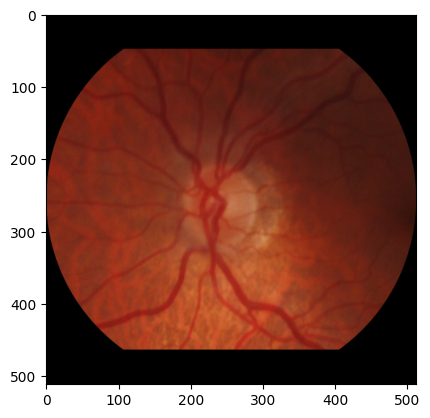

In [13]:
import os
import random

def viewFundus(image_path):

    image_path = 'full-fundus' + image_path

    print(image_path)

    image = cv2.imread(image_path)

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    plt.imshow(image_rgb)
    plt.axis('on')
    plt.show()


viewFundus(data['fundus'][12044])

In [14]:
data["types"].value_counts()

types
 0    7549
 1    4767
-1     133
Name: count, dtype: int64

In [15]:
data["types"].value_counts().sum()

12449

In [16]:
fundus_subset = data[(data['fundus'].notnull()) & (data['types'] != -1)]

fundus_subset = fundus_subset[['types', 'fundus', 'names']]

fundus_subset['combined'] = fundus_subset['names'] + '.png'

fundus_subset['fundus'] = fundus_subset['fundus'].astype(str)

fundus_subset['types'] = fundus_subset['types'].astype(str)

fundus_subset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12316 entries, 0 to 12448
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   types     12316 non-null  object
 1   fundus    12316 non-null  object
 2   names     12316 non-null  object
 3   combined  12316 non-null  object
dtypes: object(4)
memory usage: 481.1+ KB


In [17]:
fundus_subset['types'].value_counts()

types
0    7549
1    4767
Name: count, dtype: int64

In [18]:
fundus_subset

,types,fundus,names,combined
0,0,/full-fundus/OIA-ODIR-TEST-OFFLINE-1.png,OIA-ODIR-TEST-OFFLINE-1,OIA-ODIR-TEST-OFFLINE-1.png
1,0,/full-fundus/OIA-ODIR-TEST-OFFLINE-2.png,OIA-ODIR-TEST-OFFLINE-2,OIA-ODIR-TEST-OFFLINE-2.png
2,0,/full-fundus/OIA-ODIR-TEST-OFFLINE-4.png,OIA-ODIR-TEST-OFFLINE-4,OIA-ODIR-TEST-OFFLINE-4.png
3,0,/full-fundus/OIA-ODIR-TEST-OFFLINE-5.png,OIA-ODIR-TEST-OFFLINE-5,OIA-ODIR-TEST-OFFLINE-5.png
4,0,/full-fundus/OIA-ODIR-TEST-OFFLINE-6.png,OIA-ODIR-TEST-OFFLINE-6,OIA-ODIR-TEST-OFFLINE-6.png
...,...,...,...,...
12444,0,/full-fundus/FIVES-396.png,FIVES-396,FIVES-396.png
12445,0,/full-fundus/FIVES-397.png,FIVES-397,FIVES-397.png
12446,0,/full-fundus/FIVES-398.png,FIVES-398,FIVES-398.png
12447,0,/full-fundus/FIVES-399.png,FIVES-399,FIVES-399.png


In [19]:
from sklearn.model_selection import StratifiedShuffleSplit

glaucomaCount = len(fundus_subset[fundus_subset['types'] == '1'])
healthyCount = len(fundus_subset[fundus_subset['types'] == '0'])

print("this is the glaucoma count", glaucomaCount)
print("this is the healthy eyes count", healthyCount)

test_percentage = 0.10
val_percentage_from_train = 0.05 

random_state = 1

stratified_split_test = StratifiedShuffleSplit(n_splits=1, test_size=test_percentage, random_state=random_state)

for train_index, test_index in stratified_split_test.split(fundus_subset, fundus_subset['types']):
    train_set_temp = fundus_subset.iloc[train_index]
    test = fundus_subset.iloc[test_index]

stratified_split_val = StratifiedShuffleSplit(n_splits=1, test_size=val_percentage_from_train, random_state=random_state)

for train_index, val_index in stratified_split_val.split(train_set_temp, train_set_temp['types']):
    train = train_set_temp.iloc[train_index]
    val = train_set_temp.iloc[val_index]

print("\nTotal fundus images to be used:", len(fundus_subset))
print("\nTrain set size:", len(train))
print("Validation set size:", len(val))
print("Test set size:", len(test))

train_features = train.drop('types', axis=1)
train_labels = train['types']
val_features = val.drop('types', axis=1)
val_labels = val['types']
test_features = test.drop('types', axis=1)
test_labels = test['types']

this is the glaucoma count 4767
this is the healthy eyes count 7549

Total fundus images to be used: 12316

Train set size: 10529
Validation set size: 555
Test set size: 1232


In [20]:
print("Train Size: ", len(train))
print("Test Size: ", len(test))

Train Size:  10529
Test Size:  1232


In [21]:
import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-04-06 05:44:14.359855: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-06 05:44:14.651544: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-06 05:44:14.651899: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [22]:
import tensorflow as tf
from tensorflow import keras
from keras.layers.experimental.preprocessing import Rescaling
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet_v3 import preprocess_input 

target = 224
batchSize = 8

classes = 'binary'

with tf.device('/GPU:0'):


    trainDataGen = ImageDataGenerator(preprocessing_function=preprocess_input)
    trainGen = trainDataGen.flow_from_dataframe(dataframe=train, 
                                                directory='full-fundus/full-fundus', 
                                                class_mode = classes,
                                                batch_size = batchSize, 
                                                shuffle=True, 
                                                x_col="combined", 
                                                y_col="types", 
                                                validate_filenames=True, 
                                                target_size=(target, target), 
                                                color_mode='rgb')


    valDataGen = ImageDataGenerator(preprocessing_function=preprocess_input)
    valGen = valDataGen.flow_from_dataframe(dataframe=val,
                                            directory='full-fundus/full-fundus',   
                                            batch_size = batchSize, 
                                            class_mode = classes,
                                            shuffle=False, 
                                            x_col="combined", 
                                            y_col="types", 
                                            validate_filenames=True, 
                                            target_size=(target, target), 
                                            color_mode='rgb')


    testDataGen = ImageDataGenerator(preprocessing_function=preprocess_input)
    testGen = testDataGen.flow_from_dataframe(dataframe=test,
                                            directory='full-fundus/full-fundus',   
                                            batch_size = batchSize, 
                                            class_mode = classes,
                                            shuffle=False, 
                                            x_col="combined", 
                                            y_col="types", 
                                            validate_filenames=True, 
                                            target_size=(target, target), 
                                            color_mode='rgb')

2024-04-06 05:44:14.669734: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-06 05:44:14.670362: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-06 05:44:14.670787: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-06 05:44:15.058378: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-06 05:44:15.058733: I external/local_xla/xla/stream_executor

Found 10529 validated image filenames belonging to 2 classes.
Found 555 validated image filenames belonging to 2 classes.
Found 1232 validated image filenames belonging to 2 classes.


In [23]:
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.applications import MobileNetV3Small
from keras.optimizers import Adam

# Define the input shape
input_shape = (224, 224, 3)

# Load the MobileNetV3 model and assign it as the base model
base_model = MobileNetV3Small(include_top=False, weights='imagenet', input_shape=input_shape)

# Freeze the layers in the base model
for layer in base_model.layers[-20:]:
    if not isinstance(layer, BatchNormalization):
        layer.trainable = True

# Define the input image layer
input_img = Input(shape=input_shape, name='input_image')

# Pass the input image through the base model
x = base_model(input_img)

# Flatten the output from the base model
x = Flatten()(x)

# Add a dense connected layer with 512 units and a relu activation function, followed by batch normalization and dropout
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# Add a dense connected layer with 256 units and a relu activation function, followed by batch normalization and dropout
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# Add a dense output layer with 1 unit for classification and a sigmoid activation function
output = Dense(1, activation='sigmoid')(x)

# Define the model
model = Model(inputs=input_img, outputs=output)

# Compile the model
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 MobilenetV3small (Function  (None, 7, 7, 576)         939120    
 al)                                                             
                                                                 
 flatten (Flatten)           (None, 28224)             0         
                                                                 
 dense (Dense)               (None, 512)               14451200  
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 512)               0     

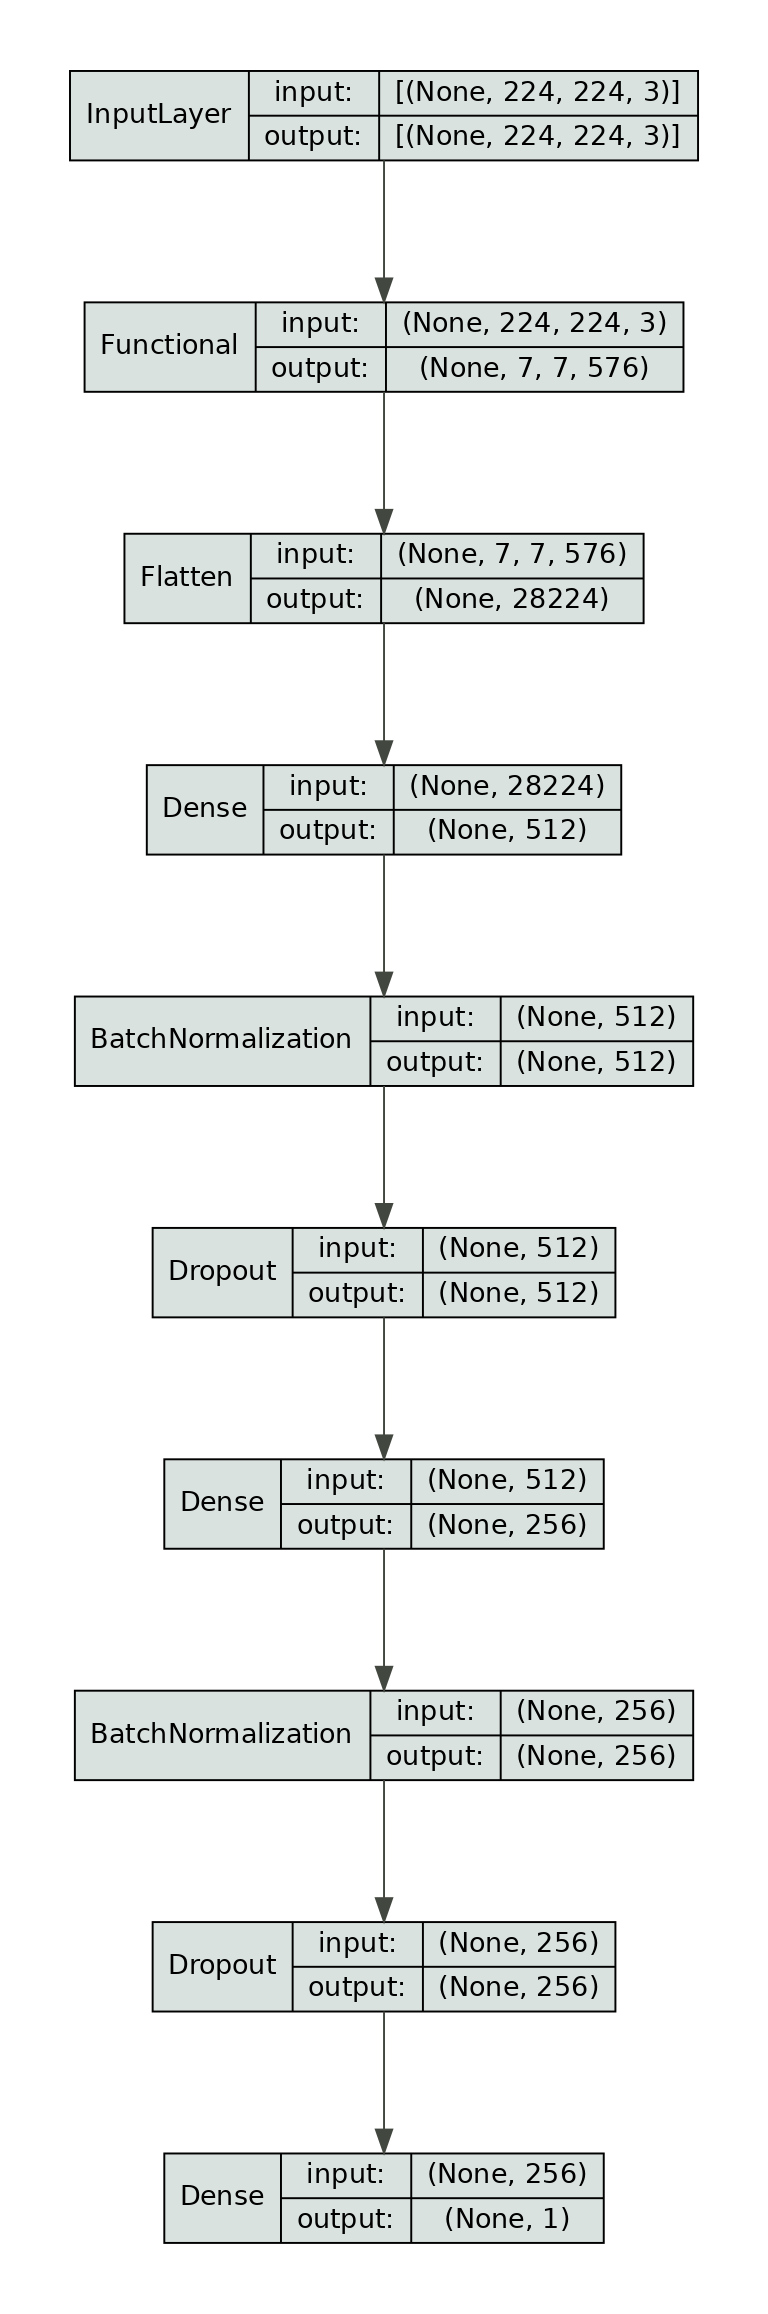

In [24]:
from keras.utils import model_to_dot
from IPython.display import Image

dot = model_to_dot(
    model,
    show_shapes=True,
    show_layer_names=False,
    rankdir='TB',
    dpi=140
)

for n in dot.get_nodes():

    n.set('style', 'filled')
    n.set('fillcolor', '#D9E2DF')
    n.set('fontname', 'Helvetica')

for e in dot.get_edges():

    e.set('color', '#42473F')
    e.set('arrowsize', '1.2')

dot.set_graph_defaults(
    bgcolor='#FFFFFF',
    pad='0.5',
    ranksep='1.0',
    nodesep='0.5'
)
dot.set_node_defaults(
    shape='box',
    style='filled',
    fillcolor='#D9E2DF',
    height='0.5',
    width='0.5',
    fontsize='10',
    color='#666666'
)
dot.set_edge_defaults(
    color='#D9E2DF',
    arrowsize='0.8',
    fontsize='10'
)

dot.write_png('architectures/model_1A_Architecture.png')
Image('architectures/model_1A_Architecture.png')

In [25]:
train_generator = trainGen
val_generator = valGen

history = model.fit(
    train_generator, 
    validation_data=val_generator, 
    steps_per_epoch=len(trainGen), 
    validation_steps=len(valGen), 
    epochs=15
)

Epoch 1/15


2024-04-06 05:44:47.907071: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-04-06 05:44:48.330524: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-06 05:44:49.034536: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-06 05:44:53.794763: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f2d747c30e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-06 05:44:53.794829: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Laptop GPU, Compute Capability 8.6
2024-04-06 05:44:53.832875: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1712367893.983963    6736 devic

1317/1317 [==============================] - 246s 161ms/step - loss: 0.6399 - accuracy: 0.7183 - val_loss: 0.4814 - val_accuracy: 0.7874
Epoch 2/15
1317/1317 [==============================] - 136s 104ms/step - loss: 0.5061 - accuracy: 0.7784 - val_loss: 0.4009 - val_accuracy: 0.8360
Epoch 3/15
1317/1317 [==============================] - 136s 103ms/step - loss: 0.4374 - accuracy: 0.8138 - val_loss: 0.3719 - val_accuracy: 0.8378
Epoch 4/15
1317/1317 [==============================] - 139s 105ms/step - loss: 0.4051 - accuracy: 0.8261 - val_loss: 0.3729 - val_accuracy: 0.8667
Epoch 5/15
1317/1317 [==============================] - 135s 103ms/step - loss: 0.3790 - accuracy: 0.8399 - val_loss: 0.3269 - val_accuracy: 0.8721
Epoch 6/15
1317/1317 [==============================] - 128s 97ms/step - loss: 0.3449 - accuracy: 0.8533 - val_loss: 0.3434 - val_accuracy: 0.8685
Epoch 7/15
1317/1317 [==============================] - 137s 104ms/step - loss: 0.3126 - accuracy: 0.8698 - val_loss: 0.3853

In [26]:
val_loss, val_accuracy = model.evaluate(valGen)
print('Validation accuracy:', val_accuracy)

test_loss, test_accuracy = model.evaluate(testGen)
print('Test accuracy:', test_accuracy)

70/70 [==============================] - 6s 82ms/step - loss: 0.4379 - accuracy: 0.8631
Validation accuracy: 0.8630630373954773
154/154 [==============================] - 22s 145ms/step - loss: 0.4346 - accuracy: 0.8742
Test accuracy: 0.8741883039474487


In [27]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

test_predictions_prob = model.predict(testGen)
test_predictions = np.where(test_predictions_prob > 0.5, 1, 0)

true_labels = testGen.classes

conf_matrix = confusion_matrix(true_labels, test_predictions)
class_report = classification_report(true_labels, test_predictions)

print("Confusion Matrix:")
print(conf_matrix)

print("\nClassification Report:")
print(class_report)

154/154 [==============================] - 15s 81ms/step
Confusion Matrix:
[[708  47]
 [108 369]]

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.94      0.90       755
           1       0.89      0.77      0.83       477

    accuracy                           0.87      1232
   macro avg       0.88      0.86      0.86      1232
weighted avg       0.88      0.87      0.87      1232



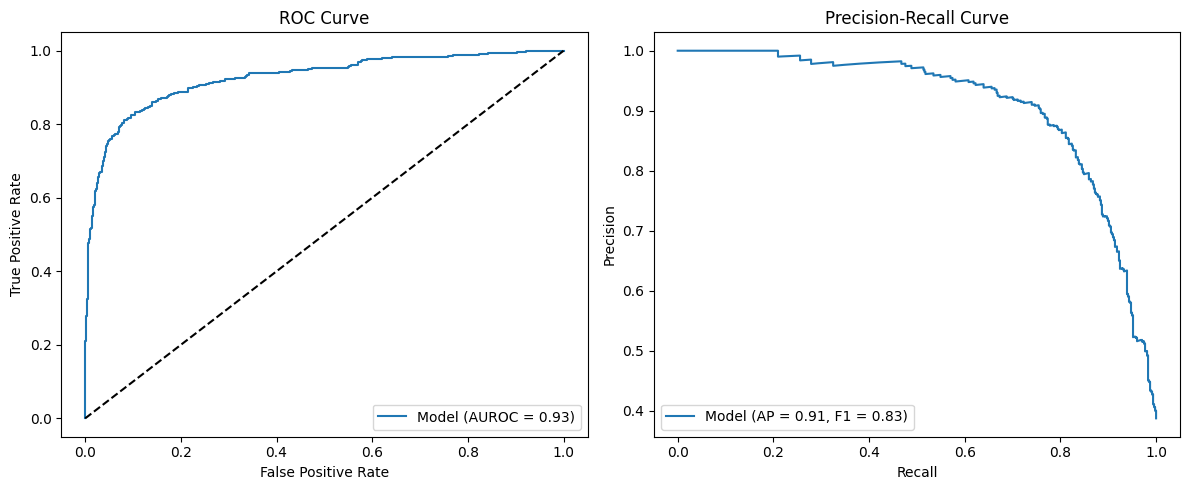

In [30]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, f1_score
import matplotlib.pyplot as plt

prob_positive_class = test_predictions_prob

fpr, tpr, _ = roc_curve(true_labels, prob_positive_class)
roc_auc = auc(fpr, tpr)

precision, recall, _ = precision_recall_curve(true_labels, prob_positive_class)
ap = average_precision_score(true_labels, prob_positive_class)
f1 = f1_score(true_labels, test_predictions)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f'Model (AUROC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f'Model (AP = {ap:.2f}, F1 = {f1:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')

plt.tight_layout()
plt.show()